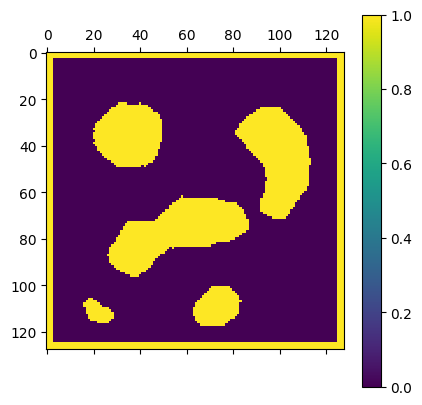

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import math

# Load grid map
image = Image.open('map0.png').convert('L')
grid_map = np.array(image.getdata()).reshape(image.size[0], image.size[1])/255
# binarize the image
grid_map[grid_map > 0.5] = 1
grid_map[grid_map <= 0.5] = 0
# Invert colors to make 0 -> free and 1 -> occupied
grid_map = (grid_map * -1) + 1
# Show grid map
plt.matshow(grid_map)
plt.colorbar()
plt.show()

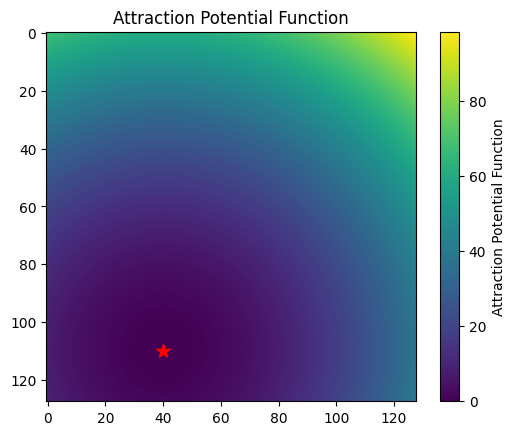

In [2]:
def attraction_potential(grid_map, goal, zita): # 4 way connectivity
    [m, n] = grid_map.shape
    att = np.zeros((m, n))
    for i, row in enumerate(grid_map):
        for j, cell in enumerate(row):
            distance = math.sqrt((goal[0] - i)**2 + (goal[1] - j)**2)   # Calculate the euclidean distance between goal and each cell
            attraction = 1/2 * zita * distance**2   # Compute the attractive potential
            att[i][j] = attraction

    plt.imshow(att, cmap='viridis')
    plt.colorbar(label='Attraction Potential Function')
    plt.title('Attraction Potential Function')
    plt.scatter([goal[1]], [goal[0]], color='red', marker='*', s=100)  # Goal as a red star
    plt.show()

    return att

attraction_map = attraction_potential(grid_map, (110, 40), 0.01)



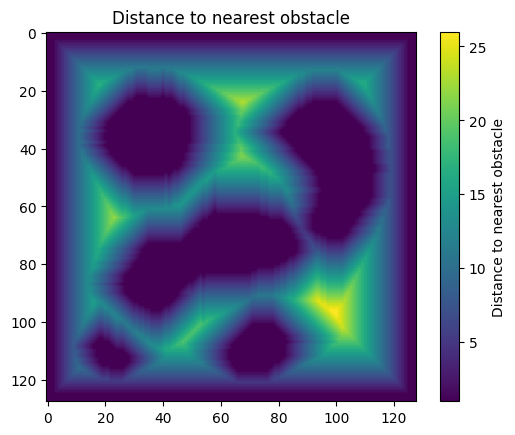

In [3]:
def within_bounds(i, j, grid_map): # Test if index lies within the bounds of a given grid map
    try:
        item = grid_map[i][j]
    except IndexError:
        return False
    return True

def four_way_neighbours(i, j, grid_map): # Return the four way neighbours of a given cell
    neighbours = []
    if within_bounds(i+1, j, grid_map):
        neighbours.append([i+1, j])
    if within_bounds(i-1, j, grid_map):
        neighbours.append([i-1, j])
    if within_bounds(i, j+1, grid_map):
        neighbours.append([i, j+1])
    if within_bounds(i, j-1, grid_map):
        neighbours.append([i, j-1])
    return neighbours

def brushfire_algorithm(grid_map):
    distance_map = grid_map.copy()
    L = []

    # Initialize the queue with boundary cells of obstacles
    for i, row in enumerate(distance_map):
        for j, cell in enumerate(row):
            if cell == 1: 
                distance_map[i][j] = 1
                L.append([i, j])

    # Process the queue
    while L:
        t = L.pop(0)
        neighbours = four_way_neighbours(t[0], t[1], distance_map)

        for n in neighbours:
            if distance_map[n[0]][n[1]] == 0:  # If d(n) is 0 i.e. if this neighbour hasn't been visited
                # Distance of unvisited neighbour is 1 plus the minimum distance of its visited neighbours
                distance_map[n[0]][n[1]] = 1 + min(
                    [distance_map[m[0]][m[1]] for m in four_way_neighbours(n[0], n[1], distance_map) if distance_map[m[0]][m[1]] != 0]
                )
                L.append(n)

    # Visualization
    plt.imshow(distance_map, cmap='viridis')
    plt.colorbar(label='Distance to nearest obstacle')
    plt.title('Distance to nearest obstacle')
    plt.show()

    return distance_map

# Assuming grid_map is defined elsewhere
distance_map = brushfire_algorithm(grid_map)


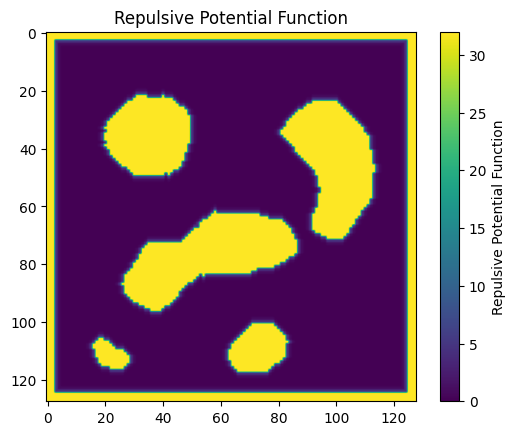

In [4]:
def repulsive_potential(distance_map, Q):
    eta = 100
    [m, n] = grid_map.shape
    rep = np.zeros((m, n))
    for i, row in enumerate(distance_map):
        for j, dist in enumerate(row):
            if dist != 0 and dist <= Q: # If cell is not an obstacle and the distance is below the threshold Q
                rep[i][j] = 1/2 * eta * (1/dist - 1/Q)**2   # Compute the repulsive potential
            else:
                rep[i][j] = 0   # If beyond the threshold the repulsive potential is 0
    rep[distance_map == 0] = np.max(rep)
    
    plt.imshow(rep, cmap='viridis')
    plt.colorbar(label='Repulsive Potential Function')
    plt.title('Repulsive Potential Function')
    plt.show()

    return rep

repulsive_map = repulsive_potential(distance_map, 5)


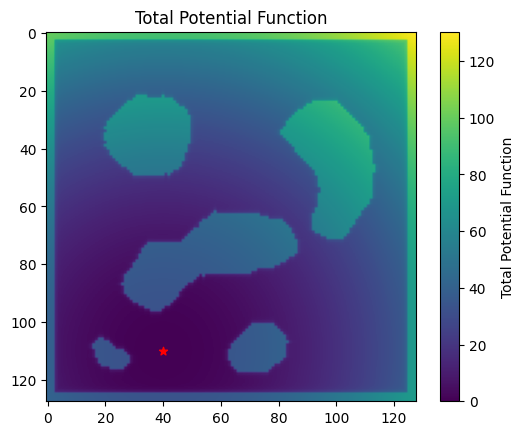

In [5]:
def total_potential(attraction_map, repulsive_map, goal):
    [m, n] = grid_map.shape
    tot = np.zeros((m, n))

    for i, row in enumerate(attraction_map):
        for j, cell in enumerate(row):
            tot[i][j] = attraction_map[i][j] + repulsive_map[i][j] # Sum the attractive and repulsive potentials
    
    plt.imshow(tot, cmap='viridis')
    plt.colorbar(label='Total Potential Function')
    plt.title('Total Potential Function')
    plt.scatter(goal[1], goal[0], color='red', marker='*')  # Mark the goal position
    plt.show()

    return tot

tot = total_potential(attraction_map, repulsive_map, (110, 40))

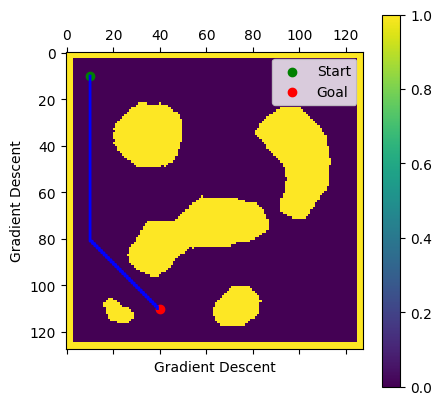

In [12]:
def calculate_gradient(tot, index):
    i = int(index[0])
    j = int(index[1])
    
    neighbours = four_way_neighbours(i, j, tot)
    
    cell_value = tot[i][j]
    # Compute difference between cell and each of its neighbours
    grads = [(cell_value - tot[ni][nj], (ni, nj)) for ni, nj in neighbours] #
    
    # Find the neighbour with the biggest negative gradient
    steepest_descent = min(grads) 

    # Compute the direction towards the steepest descent
    direction = np.array([steepest_descent[1][0] - i, steepest_descent[1][1] - j])
    return direction

def gradient_descent(grid_map, start, goal):
    alpha = 0.01
    epsilon = 1e-3
    max_iterations = 50000
    q = np.array(start, dtype=float)
    trajectory = [tuple(q)]

    for x in range(max_iterations):
        grad = calculate_gradient(tot, q)
        # Finding the gradient magnitude
        grad_norm = np.linalg.norm(grad)    
        # If near the goal exit or if the magnitude is below epsilon there could be a local minimum
        if np.linalg.norm(q - np.array(goal)) < 1 or grad_norm < epsilon: 
            break
        # Step in the direction of the gradient
        q = q - alpha * grad    
        # Clip so that q stays within the grid boundaries
        q = np.clip(q, [1, 1], np.array(grid_map.shape) - 2)
        trajectory.append(tuple(q))

    trajectory = np.array(trajectory)

    plt.matshow(grid_map)
    plt.colorbar()
    plt.plot(trajectory[:, 1], trajectory[:, 0], 'b', linewidth=2)
    plt.scatter(start[1], start[0], color='green', label='Start')
    plt.scatter(goal[1], goal[0], color='r', label='Goal')
    plt.xlabel('Gradient Descent')
    plt.ylabel('Gradient Descent')
    plt.legend()
    plt.show()

    return np.array(trajectory, dtype=int)

trajectory = gradient_descent(grid_map, (10, 10), (110, 40))

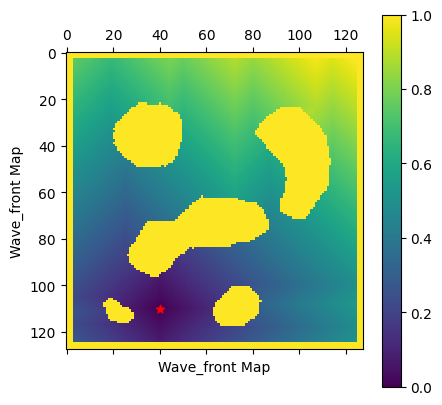

In [13]:
def wavefront_planner(grid_map, goal):
    wave_map = grid_map.copy()
    value = 2
    wave_map[goal[0]][goal[1]] = value
    queue = [list(goal)]
    while queue:
        value = value + 1
        new_queue = []
        for p in queue:
            neighbours = four_way_neighbours(p[0], p[1], grid_map)
            for n in neighbours:
                if grid_map[n[0]][n[1]] != 1 and wave_map[n[0]][n[1]] == 0: # If not an obstacle and unvisited
                    wave_map[n[0]][n[1]] = value    # Set to current distance to goal
                    new_queue.append([n[0], n[1]])
        queue = new_queue

    wave_map[wave_map == 1] = np.max(wave_map) # Set obstacles to high value so they're intraversable

    plt.matshow(wave_map)
    plt.scatter(goal[1], goal[0], color='r',marker='*')
    plt.colorbar()
    plt.xlabel("Wave_front Map")
    plt.ylabel("Wave_front Map")
    plt.show()

    return wave_map

wave_map = wavefront_planner(grid_map, (110, 40))



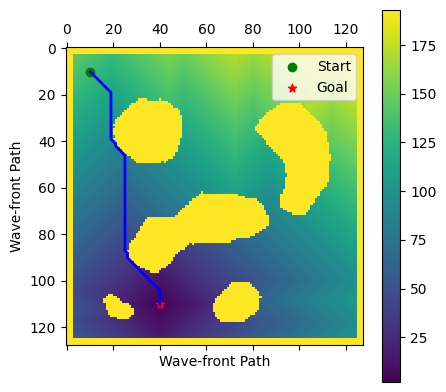

In [9]:
def find_path(wave_map, start, goal):
    q = start
    trajectory = [tuple(q)]
    
    # Define all 8 neighbors for 8-connectivity
    all_neighbors = [(-1, 0), (1, 0), (0, -1), (0, 1), 
                     (-1, -1), (-1, 1), (1, -1), (1, 1)]

    while tuple(q) != goal:
        min_distance = float('inf')
        q_prime = None

        # Check all neighbors
        for di, dj in all_neighbors:
            ni, nj = q[0] + di, q[1] + dj
            if 0 <= ni < wave_map.shape[0] and 0 <= nj < wave_map.shape[1]:
                # Skip obstacles or high-value cells if applicable
                if wave_map[ni, nj] >= np.max(wave_map):
                    continue
                # Choose the neighbor with the lowest distance value
                if wave_map[ni, nj] < min_distance:
                    min_distance = wave_map[ni, nj]
                    q_prime = [ni, nj]

        # If no valid move is found, exit
        if q_prime is None:
            print("Stuck or reached local minimum.")
            break

        q = q_prime
        trajectory.append(tuple(q))

    # Convert the trajectory list to a NumPy array for plotting
    trajectory = np.array(trajectory)

    # Plot the wavefront map with the trajectory
    plt.matshow(wave_map, cmap='viridis')
    plt.colorbar()
    plt.plot(trajectory[:, 1], trajectory[:, 0], 'b', linewidth=2)
    plt.scatter(start[1], start[0], color='green', label='Start')
    plt.scatter(goal[1], goal[0], color='red', label='Goal', marker='*')
    plt.xlabel("Wave-front Path")
    plt.ylabel("Wave-front Path")
    plt.legend()
    plt.show()

    return trajectory
trajectory = find_path(wave_map, (10, 10), (110, 40))
